In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import TensorDataset, DataLoader, random_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from tqdm import tqdm #para poder ver las barritas de % cargandose cuando va iterando
from PIL import Image as im

In [2]:
#Para usar solo 24 cores que me dijo NW
torch.set_num_threads(24)

# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)

In [3]:
# Function to save the model 
def saveModel(model): 
    path = "./Modelos_Fiteados/AEC/AEC_ultima.pth" 
    torch.save(model.state_dict(), path)

In [4]:
#Bajo el MNIST
train_dataset = torchvision.datasets.MNIST('./', train=True, download=True)
test_dataset = torchvision.datasets.MNIST('./', train=False, download=True)

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

In [5]:
print(int(m-m*0.2),'----',int(m*0.2))

48000 ---- 12000


In [ ]:
# #Bajo el FashionMNIST
# train_dataset = torchvision.datasets.FashionMNIST('./', train=True, download=True)
# test_dataset = torchvision.datasets.FashionMNIST('./', train=False, download=True)

# m=len(train_dataset)

# train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

In [6]:
X_train = [x[0] for x in train_data]
y_train = [x[1] for x in train_data]

X_val = [x[0] for x in val_data]
Y_val = [x[1] for x in val_data]

X_test = [x[0] for x in test_dataset]
Y_test = [x[1] for x in test_dataset]

RX_train = [0]*(10*len(X_train))
RY_train = [0]*(10*len(X_train))

RX_val = [0]*(10*len(X_val))
RY_val = [0]*(10*len(X_val))

RX_test = [0]*(10*len(X_test))
RY_test = [0]*(10*len(X_test))

In [7]:
rotador = torchvision.transforms.functional.rotate

In [8]:
for i in range(len(X_train)):
    for j in range(10):
        ang = random.randint(-60,60)
        RX_train[i*10+j]=rotador(X_train[i],ang)
        RY_train[i*10+j]=X_train[i]
        
for i in range(len(X_val)):
    for j in range(10):
        ang = random.randint(-60,60)
        RX_val[i*10+j]=rotador(X_val[i],ang)
        RY_val[i*10+j]=X_val[i]
    
for i in range(len(X_test)):
    for j in range(10):
        ang = random.randint(-60,60)
        RX_test[i*10+j]=rotador(X_test[i],ang)
        RY_test[i*10+j]=X_test[i]

In [ ]:
# print(RX_test[0].mode)

# #torchvision.transforms.ToTensor[SOURCE]
# # Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.

# # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor 
# # of shape (C x H x W) in the range [0.0, 1.0] 
# # if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
# # or if the numpy.ndarray has dtype = np.uint8

# # In the other cases, tensors are returned without scaling.


# #ES L asi que tengo toda la data normalizada despues ! Joya

In [ ]:
# # Plot some samples
# fig, axs = plt.subplots(5, 5, figsize=(8,8))
# i = 0
# for ax in axs.flatten():
#     # random.choice allows to randomly sample from a list-like object 
#     #(basically anything that can be accessed with an index, like our dataset)
#     #img, label = random.choice(train_dataset)
#     ax.imshow(np.array(RX_train[i*20]), cmap='gist_gray')
# #     ax.set_title(f'Angle: {round((Rang_train[i*20]),2)}')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     i +=1
# #plt.savefig('./Img/clothe_samples.svg', format='svg')
# plt.tight_layout()

In [9]:
#hago la transformacion a tensores
to_tensor = torchvision.transforms.ToTensor()

#los convierto a tensores con la transformacion
tensor_RX_train = [to_tensor(RX_train[i]).unsqueeze(0) for i in range(len(RX_train))]
tensor_RX_train = torch.cat(tensor_RX_train)

tensor_RY_train = [to_tensor(RY_train[i]).unsqueeze(0) for i in range(len(RY_train))]
tensor_RY_train = torch.cat(tensor_RY_train)

tensor_RX_val = [to_tensor(RX_val[i]).unsqueeze(0) for i in range(len(RX_val))]
tensor_RX_val = torch.cat(tensor_RX_val)

tensor_RY_val = [to_tensor(RY_val[i]).unsqueeze(0) for i in range(len(RY_val))]
tensor_RY_val = torch.cat(tensor_RY_val)

tensor_RX_test = [to_tensor(RX_test[i]).unsqueeze(0) for i in range(len(RX_test))]
tensor_RX_test = torch.cat(tensor_RX_test)

tensor_RY_test = [to_tensor(RY_test[i]).unsqueeze(0) for i in range(len(RY_test))]
tensor_RY_test = torch.cat(tensor_RY_test)

In [10]:
#Datasets
tensor_datatrain = TensorDataset(tensor_RX_train, tensor_RY_train)
train_loader = DataLoader(tensor_datatrain, batch_size=5000, shuffle=True)

tensor_dataval = TensorDataset(tensor_RX_val, tensor_RY_val)
val_loader = DataLoader(tensor_dataval, batch_size=5000, shuffle=True)

tensor_datatest = TensorDataset(tensor_RX_test, tensor_RY_test)
test_loader = DataLoader(tensor_datatest, batch_size=1)

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, nf, latent_dim):
        super().__init__()
        
        ### Encoder
        self.encoder = nn.Sequential(nn.Conv2d(in_channels  = 1,       # First convolutional layer
                                               out_channels = nf,
                                               kernel_size  = 3,
                                               stride       = 1,
                                               padding      = 1),
                                     nn.ReLU(True),                    
                                     nn.Conv2d(in_channels  = nf,      # Second convolutional layer
                                               out_channels = 2 * nf,
                                               kernel_size  = 3,
                                               stride       = 1,
                                               padding      = 1),
#                                      nn.BatchNorm2d(16),
                                     nn.ReLU(True),                    
                                     nn.Conv2d(in_channels  = 2 * nf,  # Third convolutional layer
                                               out_channels = 4 * nf,
                                               kernel_size  = 3,
                                               stride       = 2,
                                               padding      = 1),       #Out 14*14*32
                                     nn.ReLU(True))
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(nn.Linear(14*14*(4*nf), 1024),
                                         nn.ReLU(True),
                                         nn.Linear(1024, latent_dim))
        
        ### Decoder
        
        self.decoder_lin = nn.Sequential(nn.Linear(latent_dim, 1024),
                                         nn.ReLU(True),
                                         nn.Linear(1024, 14*14*(4*nf)),
                                         nn.ReLU(True))

        self.unflatten = nn.Unflatten(dim=1,
                                      unflattened_size=((4*nf), 14, 14))

        self.decoder = nn.Sequential(nn.ConvTranspose2d(in_channels    = 4 * nf,   # First transposed convolution
                                                        out_channels   = 2 * nf,
                                                        kernel_size    = 3,
                                                        stride         = 2,
                                                        padding        = 1,
                                                        output_padding = 1),
#                                      nn.BatchNorm2d(16),
                                     nn.ReLU(True),
                                     nn.ConvTranspose2d(in_channels    = 2 * nf,    # Second transposed convolution
                                                        out_channels   = nf,
                                                        kernel_size    = 3,
                                                        stride         = 1,
                                                        padding        = 1,
                                                        output_padding = 0),
                                     nn.ReLU(True),
                                     nn.ConvTranspose2d(in_channels    = nf,        # Third transposed convolution
                                                        out_channels   = 1,
                                                        kernel_size    = 3,
                                                        stride         = 1,
                                                        padding        = 1,
                                                        output_padding = 0))
        
    def forward(self, x):
        x = self.encoder(x)
        x1 = torch.clone(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x, x1

In [12]:
learning_rate     = 1e-3
regularization    = 1e-4
nf                = 16
latent_dim        = 128

AEC = Autoencoder(nf,latent_dim)

loss_fn = torch.nn.MSELoss()

params_to_optimize = [{'params': AEC.encoder.parameters()},
                      {'params': AEC.decoder.parameters()}]

optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
AEC.to(device)

Selected device: cpu


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=12544, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=128, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=128, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=12544, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(64, 14, 14))
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
   

In [ ]:
# AEC.load_state_dict(torch.load("./Modelos_Fiteados/AEC/AEC_1024_2.pth"))

In [23]:
### Training function
def train_epoch(AEC, device, dataloader, loss_fn, optimizer):
    AEC.train()
    train_loss = []
    for data, label in dataloader:
        # Move data to device
        data = data.to(device)
        label = label.to(device)
        # process
        processed = AEC.forward(data)[0]
        # Compute loss
        loss = loss_fn(processed, label)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ###
        loss = loss.detach().cpu().numpy()
        train_loss.append(loss)
    return np.mean(train_loss)    

In [24]:
### Testing function
def test_epoch(AEC, device, dataloader, loss_fn):
    AEC.eval()
    test_loss = []
    with torch.no_grad():
        for data, label in dataloader:
            # Move tensor to the proper device
            data = data.to(device)
            label = label.to(device)
            # output
            processed = AEC.forward(data)[0]
            # Compute loss
            loss = loss_fn(processed, label)
            #Save test loss for this batch
            loss = loss.detach().cpu().numpy()
            test_loss.append(loss)
    return np.mean(test_loss)

In [ ]:
# def plot_ae_outputs(AEC, n=10):
#     plt.figure(figsize=(16,4.5))
#     targets = tensor_datatest.targets.numpy()
#     t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
#     for i in range(n):
#         ax = plt.subplot(2,n,i+1)
#         img = tensor_datatest[t_idx[i]][0].unsqueeze(0).to(device)
#         encoder.eval()
#         decoder.eval()
#         with torch.no_grad():
#             rec_img  = decoder(encoder(img))
#         plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
#         if i == n//2:
#             ax.set_title('Original images')
#         ax = plt.subplot(2, n, i + 1 + n)
#         plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
#         if i == n//2:
#             ax.set_title('Reconstructed images')
#         plt.show()   

In [21]:
def early_stopping(train_loss, validation_loss, min_delta, tolerance):

    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
            return True

In [25]:
num_epochs = 30
diz_loss = {'train_loss_1':[],'train_loss_2':[],'val_loss':[]}
for epoch in tqdm(range(num_epochs)):
    train_loss_1 = train_epoch(AEC,
                               device,
                               train_loader,
                               loss_fn,
                               optim)
    train_loss_2 = test_epoch(AEC,
                              device,
                              train_loader,
                              loss_fn)
    val_loss = test_epoch(AEC,
                          device,
                          val_loader,
                          loss_fn)
    print('\n EPOCH {}/{} \t train loss_1 {} \t train loss_2 {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss_1,train_loss_2,val_loss))
    diz_loss['train_loss_1'].append(train_loss_1)
    diz_loss['train_loss_2'].append(train_loss_2)
    diz_loss['val_loss'].append(val_loss)
#     plot_ae_outputs(AEC, n=10)
# early stopping
    if early_stopping(train_loss_2, val_loss, min_delta=0.001, tolerance = 5):
      print("We are at epoch:", i)
      break

  3%|██▌                                                                           | 1/30 [08:55<4:18:36, 535.06s/it]


 EPOCH 1/30 	 train loss_1 0.08724325895309448 	 train loss_2 0.06387387961149216 	 val loss 0.06383249908685684


  7%|█████▏                                                                        | 2/30 [17:53<4:10:32, 536.86s/it]


 EPOCH 2/30 	 train loss_1 0.060944508761167526 	 train loss_2 0.058346208184957504 	 val loss 0.058201324194669724


 10%|███████▊                                                                      | 3/30 [27:02<4:04:09, 542.57s/it]


 EPOCH 3/30 	 train loss_1 0.056329261511564255 	 train loss_2 0.05443910136818886 	 val loss 0.054224539548158646


 13%|██████████▍                                                                   | 4/30 [35:59<3:54:09, 540.35s/it]


 EPOCH 4/30 	 train loss_1 0.0532599538564682 	 train loss_2 0.05203661322593689 	 val loss 0.05180441215634346


 17%|█████████████                                                                 | 5/30 [45:04<3:45:48, 541.94s/it]


 EPOCH 5/30 	 train loss_1 0.051224227994680405 	 train loss_2 0.050180599093437195 	 val loss 0.049951422959566116


 20%|███████████████▌                                                              | 6/30 [54:00<3:35:59, 539.97s/it]


 EPOCH 6/30 	 train loss_1 0.049735862761735916 	 train loss_2 0.04883076623082161 	 val loss 0.04860011860728264


 23%|█████████████████▋                                                          | 7/30 [1:02:56<3:26:26, 538.55s/it]


 EPOCH 7/30 	 train loss_1 0.04864149168133736 	 train loss_2 0.048546671867370605 	 val loss 0.04832061007618904


 27%|████████████████████▎                                                       | 8/30 [1:11:53<3:17:17, 538.07s/it]


 EPOCH 8/30 	 train loss_1 0.04763292148709297 	 train loss_2 0.04698904976248741 	 val loss 0.04676090553402901


 30%|██████████████████████▊                                                     | 9/30 [1:20:48<3:08:01, 537.22s/it]


 EPOCH 9/30 	 train loss_1 0.04682819917798042 	 train loss_2 0.0462191142141819 	 val loss 0.0459911972284317


 33%|█████████████████████████                                                  | 10/30 [1:31:32<3:10:01, 570.09s/it]


 EPOCH 10/30 	 train loss_1 0.0463634692132473 	 train loss_2 0.04559098556637764 	 val loss 0.04535786807537079


 37%|███████████████████████████▍                                               | 11/30 [1:43:25<3:14:24, 613.92s/it]


 EPOCH 11/30 	 train loss_1 0.04557189345359802 	 train loss_2 0.04493182525038719 	 val loss 0.044705625623464584


 40%|██████████████████████████████                                             | 12/30 [1:55:28<3:14:10, 647.24s/it]


 EPOCH 12/30 	 train loss_1 0.04508045315742493 	 train loss_2 0.04443703219294548 	 val loss 0.0442068986594677


 43%|████████████████████████████████▌                                          | 13/30 [2:06:55<3:06:48, 659.32s/it]


 EPOCH 13/30 	 train loss_1 0.04476649686694145 	 train loss_2 0.04418747127056122 	 val loss 0.04395231232047081


 47%|███████████████████████████████████                                        | 14/30 [2:18:25<2:58:15, 668.44s/it]


 EPOCH 14/30 	 train loss_1 0.04430386424064636 	 train loss_2 0.04363253340125084 	 val loss 0.04339981451630592


 50%|█████████████████████████████████████▌                                     | 15/30 [2:30:28<2:51:11, 684.74s/it]


 EPOCH 15/30 	 train loss_1 0.04391178861260414 	 train loss_2 0.043303389102220535 	 val loss 0.04307172819972038


 53%|████████████████████████████████████████                                   | 16/30 [2:42:06<2:40:44, 688.91s/it]


 EPOCH 16/30 	 train loss_1 0.04362541437149048 	 train loss_2 0.04326711595058441 	 val loss 0.04304642602801323


 57%|██████████████████████████████████████████▌                                | 17/30 [2:53:26<2:28:40, 686.20s/it]


 EPOCH 17/30 	 train loss_1 0.04353995993733406 	 train loss_2 0.043859634548425674 	 val loss 0.04363283887505531


 60%|█████████████████████████████████████████████                              | 18/30 [3:05:10<2:18:19, 691.63s/it]


 EPOCH 18/30 	 train loss_1 0.04289691150188446 	 train loss_2 0.04343707859516144 	 val loss 0.04322316125035286


 63%|███████████████████████████████████████████████▌                           | 19/30 [3:16:41<2:06:45, 691.41s/it]


 EPOCH 19/30 	 train loss_1 0.04285407066345215 	 train loss_2 0.04219025745987892 	 val loss 0.04196320101618767


 67%|██████████████████████████████████████████████████                         | 20/30 [3:28:38<1:56:29, 698.90s/it]


 EPOCH 20/30 	 train loss_1 0.04258148372173309 	 train loss_2 0.043487537652254105 	 val loss 0.04327849671244621


 70%|████████████████████████████████████████████████████▌                      | 21/30 [3:40:18<1:44:54, 699.39s/it]


 EPOCH 21/30 	 train loss_1 0.042367398738861084 	 train loss_2 0.04221336171030998 	 val loss 0.04198524355888367


 73%|██████████████████████████████████████████████████████▉                    | 22/30 [3:52:14<1:33:55, 704.42s/it]


 EPOCH 22/30 	 train loss_1 0.04219767078757286 	 train loss_2 0.04198750853538513 	 val loss 0.04177433252334595


 77%|█████████████████████████████████████████████████████████▌                 | 23/30 [4:03:39<1:21:30, 698.66s/it]


 EPOCH 23/30 	 train loss_1 0.04196948930621147 	 train loss_2 0.04342874884605408 	 val loss 0.043225374072790146


 80%|████████████████████████████████████████████████████████████               | 24/30 [4:15:34<1:10:19, 703.31s/it]


 EPOCH 24/30 	 train loss_1 0.04186807945370674 	 train loss_2 0.04159406200051308 	 val loss 0.041370946913957596


 83%|████████████████████████████████████████████████████████████████▏            | 25/30 [4:25:57<56:36, 679.22s/it]


 EPOCH 25/30 	 train loss_1 0.04160332679748535 	 train loss_2 0.04101384058594704 	 val loss 0.04079682007431984


 87%|██████████████████████████████████████████████████████████████████▋          | 26/30 [4:34:52<42:23, 635.96s/it]


 EPOCH 26/30 	 train loss_1 0.04139801487326622 	 train loss_2 0.041031066328287125 	 val loss 0.0408175103366375


 90%|█████████████████████████████████████████████████████████████████████▎       | 27/30 [4:43:47<30:17, 605.83s/it]


 EPOCH 27/30 	 train loss_1 0.04123920202255249 	 train loss_2 0.04068225249648094 	 val loss 0.04047028347849846


 93%|███████████████████████████████████████████████████████████████████████▊     | 28/30 [4:52:42<19:29, 584.61s/it]


 EPOCH 28/30 	 train loss_1 0.041052136570215225 	 train loss_2 0.04109294340014458 	 val loss 0.040889471769332886


 97%|██████████████████████████████████████████████████████████████████████████▍  | 29/30 [5:01:38<09:30, 570.03s/it]


 EPOCH 29/30 	 train loss_1 0.040943920612335205 	 train loss_2 0.04099145531654358 	 val loss 0.04077664017677307


100%|█████████████████████████████████████████████████████████████████████████████| 30/30 [5:10:34<00:00, 621.16s/it]


 EPOCH 30/30 	 train loss_1 0.04092252254486084 	 train loss_2 0.040170036256313324 	 val loss 0.03995911404490471


In [26]:
saveModel(AEC)

In [27]:
np.savetxt('./Modelos_Fiteados/losses/AEC/NUEVAS/train_ultimo_1',diz_loss['train_loss_1'])
np.savetxt('./Modelos_Fiteados/losses/AEC/NUEVAS/train_ultimo_2',diz_loss['train_loss_2'])
np.savetxt('./Modelos_Fiteados/losses/AEC/NUEVAS/val_ultimo',diz_loss['val_loss'])

# train_loss = np.loadtxt()
# test_loss = np.loadtxt()

In [ ]:
test_epoch(AEC, device, test_loader, loss_fn).item()

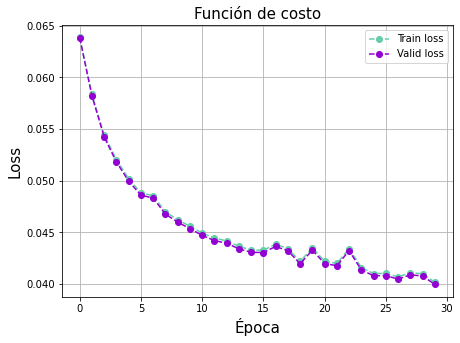

In [28]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.plot(diz_loss['train_loss_2'], linestyle='--', marker='o',  label='Train loss', c='mediumaquamarine')
plt.plot(diz_loss['val_loss'], linestyle='--', marker='o', label='Valid loss', c='darkviolet')
plt.xlabel('Época',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Función de costo",fontsize=15)
plt.grid()
plt.legend()
plt.savefig('./Modelos_Fiteados/Imagenes/AEC/NUEVAS/errores_AEC.png', format='png')
plt.show()

In [ ]:
# # Plot losses
# plt.figure(figsize=(10,8))
# plt.plot(diz_loss['train_loss'], label='Train')
# plt.plot(diz_loss['val_loss'], label='Valid')

# plt.xlabel('Epoch')
# plt.ylabel('Average Loss')
# plt.legend()
# #plt.title('loss')
# plt.show()

In [ ]:
elements = [110,121,130,140]

fig, axs = plt.subplots(3, 4, figsize=(12,6))
fig.suptitle('Original, rotada and reconstructed image',fontsize=15)
fig.subplots_adjust(top=0.88)
axs = axs.ravel()

for i in range (4):
    img   = to_tensor(RX_test[elements[i]]).unsqueeze(0).to(device)
    label = to_tensor(RY_test[elements[i]]).unsqueeze(0).to(device)
    with torch.no_grad():
        AEC.eval()
        rec_img  = AEC(img)[0]        
    # Plot the reconstructed image  
    axs[i].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[i].set_title('img')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+4].imshow(label.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[i+4].set_title('original')
    axs[i+4].set_xticks([])
    axs[i+4].set_yticks([])
    axs[i+8].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[i+8].set_title('Reconstructed image')
    axs[i+8].set_xticks([])
    axs[i+8].set_yticks([])
#     plt.savefig('./Modelos_Fiteados/Imagenes/AEC/recons_1024.png', format='png')
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)

veamos activaciones a ver

In [ ]:
i=140

activaciones = np.empty(shape=(64,14,14))

img   = to_tensor(RX_test[i]).unsqueeze(0).to(device)
label = to_tensor(RY_test[i]).unsqueeze(0).to(device)
with torch.no_grad():
    AEC.eval()
    activ = AEC.forward(img)[1]
    activaciones = activ

In [ ]:
# print(activaciones[0,0])

plt.imshow(activaciones[0,0])
plt.colorbar()

In [ ]:
# print(activaciones.shape)

In [ ]:
fig, axs = plt.subplots(8, 8, figsize=(8,8))
i = 0
for ax in axs.flatten():
    ax.imshow(activaciones[0,i], cmap='gist_gray')
    ax.set_xticks([])
    ax.set_yticks([])
    i +=1
plt.tight_layout()
plt.savefig('./Modelos_Fiteados/Imagenes/AEC/activaciones_1024_1s.png', format='png')

In [ ]:
# for i,j in AEC.named_parameters():
#     print(i,j)

### Visualizacion de filtros

In [ ]:
model_weights = [] 
conv_layers = [] 
model_children = list(AEC.encoder.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

In [ ]:
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(8, 8))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(4, 4, i+1) # we have 3x3 filters and total of 8 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='gist_gray')
    plt.axis('off')
    plt.savefig('./Modelos_Fiteados/Imagenes/AEC/filtros_c1.png', format='png')
plt.show()

In [ ]:
# visualize the 2nd conv layer filters
plt.figure(figsize=(12,12))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(4, 8, i+1) # we have 3x3 filters and total of 16 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='gist_gray')
    plt.axis('off')
    plt.savefig('./Modelos_Fiteados/Imagenes/AEC/filtros_c2.png', format='png')
plt.show()

In [ ]:
# visualize the 3th conv layer filters
plt.figure(figsize=(2*8,2*8))
for i, filter in enumerate(model_weights[2]):
    plt.subplot(8, 8, i+1) # we have 3x3 filters and total of 32 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='gist_gray')
    plt.axis('off')
    plt.savefig('./Modelos_Fiteados/Imagenes/AEC/filtros_c3.png', format='png')
plt.show()

Visualización del espacio latente con t-SNE

In [ ]:
# encoded_samples = []
# for sample in tqdm(tensor_datatest):
#     img = sample[0].unsqueeze(0).to(device)
#     label = sample[1]
#     # Encode image    
#     AEC.eval()
#     with torch.no_grad():
#         encoded_img  = AEC.encoder(img)
#     # Append to list
#     encoded_img = encoded_img.flatten().cpu().numpy()
#     encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
#     encoded_sample['label'] = label
#     encoded_samples.append(encoded_sample)
# encoded_samples = pd.DataFrame(encoded_samples)
# encoded_samples

In [ ]:
# encoded_samples.to_csv('./Modelos_Fiteados/AEC/encoded_samples.csv', header=False, index=False)

# # encoded_asmples =pd.read_csv('./Modelos_Fiteados/AEC/encoded_samples.csv')

In [ ]:
# import plotly.express as px

# px.scatter(encoded_samples,
#            x='Enc. Variable 0',
#            y='Enc. Variable 1',
#            color=encoded_samples.label.astype(str),
#            opacity=0.7)